# Progress Report

In [19]:
import torch
import esm
import pandas as pd
import requests
import os
from tqdm import tqdm
import numpy as np
from sequence_models.pretrained import load_model_and_alphabet

In [3]:
# Load Model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [4]:
# Load Data
url = "https://elifesciences.org/download/aHR0cHM6Ly9jZG4uZWxpZmVzY2llbmNlcy5vcmcvYXJ0aWNsZXMvMTY5NjUvZWxpZmUtMTY5NjUtc3VwcDEtdjQueGxzelife-16965-supp1-v4.xlsx?_hash=UsG4XAO0qnBOtjEvbXpBgu%2FazhuWskkDqs417%2BIpaAM%3D"
r = requests.get(url, allow_redirects=True)
filepath = 'data/gb1data.xlsx'
if not os.path.exists(filepath):
    with open(filepath, 'wb') as f:
        f.write(r.content)
GB1_data = pd.read_excel(filepath)

/Users/esmirmesic/opt/anaconda3/envs/cs144/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
# Load sequences
with open("data/GB1_Wu_2016.fasta", "r") as f:
    f.readline() # Skip the header
    wildtype = f.read().replace("\n", "")

sites = [39, 40, 41, 54]

In [6]:
# One-hot encode sequences
aa_list = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P","Q", "R", "S", "T", "V", "W", "Y"]
aa_to_onehot = {aa: np.eye(len(aa_list))[i] for i, aa in enumerate(aa_list)}
# Create a one-hot encoding for the wild-type sequence
onehot_wildtype = np.array([aa_to_onehot[aa] for aa in wildtype])

def encode_mutants_onehot(row, onehot_wildtype):
    mutant = onehot_wildtype.copy()
    mutations = row['Variants']
    for i, mutation in enumerate(mutations):
        mutant[sites[i]-1] = aa_to_onehot[mutation]
    return mutant
def encode_sequence(row, wild):
    mutant = list(wild)
    mutations = row['Variants']
    for i, mutation in enumerate(mutations):
        mutant[sites[i]-1] = mutation
    mutant = "".join(mutant)
    return mutant

In [7]:
# Apply processing for dataframe to get sequence/onehot
rows = len(GB1_data)
tqdm.pandas(total=rows)
GB1_data['onehot_sequence'] = GB1_data.progress_apply(lambda row: encode_mutants_onehot(row, onehot_wildtype), axis=1)
GB1_data['full_sequence'] = GB1_data.progress_apply(lambda row: encode_sequence(row, wildtype), axis=1)

100%|██████████| 149361/149361 [00:00<00:00, 192352.05it/s]


In [9]:
# Get masked sequence
to_mask_sequence = list(wildtype)
for site in sites:
    to_mask_sequence[site-1] = "<mask>"
masked_sequence = "".join(to_mask_sequence)
masked_sequence

'MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNG<mask><mask><mask>EWTYDDATKTFT<mask>TE'

In [11]:
# Add data
data = [
    ("GB1", masked_sequence),
]

In [12]:
def get_prediction(data):
    # Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]

    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    sequence_representations = []
    for i, tokens_len in enumerate(batch_lens):
        sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

    # Look at the unsupervised self-attention map contact predictions
    import matplotlib.pyplot as plt
    for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
        plt.matshow(attention_contacts[: tokens_len, : tokens_len])
        plt.title(seq)
        plt.show()
    predicted_tokens = torch.argmax(results["logits"], dim=-1)
    predicted_sequence = "".join([alphabet.all_toks[token_idx.item()] for token_idx in predicted_tokens[0]])[5:-5]
    return predicted_sequence

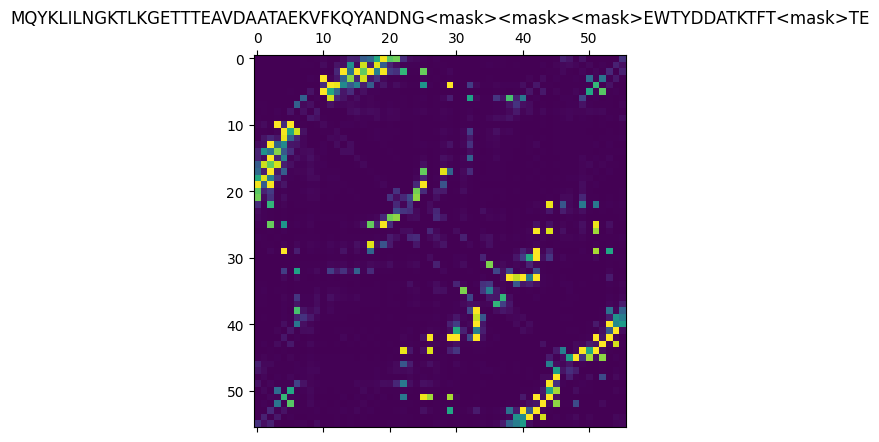

In [13]:
predicted_sequence = get_prediction(data)

In [15]:
def get_variant(predicted_sequence, gb1_data):
    variant = "".join([predicted_sequence[site-1] for site in sites])
    return gb1_data[gb1_data['Variants'] == variant]

In [16]:
variant_prediction = get_variant(predicted_sequence, GB1_data)

In [17]:
variant_prediction

,Variants,HD,Count input,Count selected,Fitness,onehot_sequence,full_sequence
12083,LTGL,3,2946,4689,0.436245,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLTGEWTYD...


In [20]:
model, collater = load_model_and_alphabet('carp_640M')

Downloading: "https://zenodo.org/record/6564798/files/carp_640M.pt?download=1" to /Users/esmirmesic/.cache/torch/hub/checkpoints/carp_640M.pt


In [ ]:
from sequence_models.pdb_utils import parse_PDB, process_coords
coords, wt, _ = parse_PDB('examples/gb1_a60fb_unrelaxed_rank_1_model_5.pdb')
coords = {
        'N': coords[:, 0],
        'CA': coords[:, 1],
        'C': coords[:, 2]
    }
dist, omega, theta, phi = process_coords(coords)
batch = [[wt, torch.tensor(dist, dtype=torch.float),
          torch.tensor(omega, dtype=torch.float),
          torch.tensor(theta, dtype=torch.float), torch.tensor(phi, dtype=torch.float)]]
src, nodes, edges, connections, edge_mask = collater(batch)
# can use result='repr' or result='logits'. Default is 'repr'.
rep = model(src, nodes, edges, connections, edge_mask)  

# What progress has been done

So far, we have preprocessed the data, implemented ESM for inference using the pretrained model, implemented functions to extract fitness from predicted variants, and have started to implement CARP.

In addition to the above, we have done some research into how to fine-tune ESM for our purposes and also what other datasets we can bring in that could give us similar insights to GB1. 


# Challenges

There was little documentation on how to get the actual sequences out of the ESM model, so we used a combination of the internet and chat-gpt to get us through it and we think what we have makes sense. 

Additonally, getting models to work locally has been a challenge sine we both have M1/M2 macbooks which have some glitches with newer versions of pytorch and python. This also took a long time to debug. Later on, when we bring in larger ESM and CARP models and more data we will likely run it on the class cluster.

Finally, We are having trouble finding documentation on doing masked sequence prediction with CARP and are currently researching more into this.


# Next steps

Our next steps are to implement fine-tuning for ESM so that we can run comparisons to the pre-trained and the fine-tuned ESM for different model sizes and get a wide range of comparisons.

We are also working on finding other datasets to bring in to compare to the performance on the GB1 dataset.

Finally, we are in the process of implementing Microsoft's CARP model for this task and will likely have it ready by early next week.